### Test different thresholds of IPC levels for FewsNet and Global IPC
For the anticipatory action framework, we want to define the trigger mechanism based on data. One of the possible data sources are IPC levels. Based on the historical analysis of FewsNet and Global IPC, and conversations with partners, different triggers were tested. This notebook provides a subset of tested triggers and the code to easily test any triggers of interest.   

IPC trigger design as endorsed early 2020 (no forecast period- ML1 or ML2 -was specified):   

- The projected population in phase 3 and above exceed 20%, AND 
- The projected population in phase 3 is projected to increase by a further 5%, OR 
- The projected population in phase 4 or above is 2.5%

Main experimenting was done with FewsNet due to more historical data. The most relevant triggers were also analysed for Global IPC.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
country="somalia"

In [3]:
df_fadm=pd.read_csv(f"../Data/FewsNetProcessed/{country}_fewsnet_admin1.csv",index_col=0)
adm1c='admin1Name' #"ADMIN1" #
admc="admin1Name"

In [4]:
df_fadm

,date,admin1Name,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,ML1_4,ML1_5,ML2_1,ML2_2,ML2_3,ML2_4,ML2_5,pop_CS,pop_ML1,pop_ML2
0,2009-07-01,Awdal,673264,639957,0.0,73144.0,378890.0,0.0,0.0,0.0,...,0.0,0.0,0.0,452034.0,0.0,0.0,0.0,452034.0,452034.0,452034.0
1,2009-07-01,Bakool,367227,349058,0.0,0.0,91992.0,0.0,0.0,0.0,...,91992.0,0.0,0.0,0.0,91992.0,0.0,0.0,91992.0,91992.0,91992.0
2,2009-07-01,Banadir,1650228,1568592,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-07-01,Bari,730147,694025,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-07-01,Bay,792182,752991,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,2020-10-01,Nugaal,392697,491937,0.0,81380.0,410557.0,0.0,0.0,0.0,...,0.0,0.0,0.0,81380.0,410557.0,0.0,0.0,491937.0,491937.0,491937.0
734,2020-10-01,Sanaag,544123,681631,0.0,0.0,681631.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,681631.0,0.0,0.0,681631.0,681631.0,681631.0
735,2020-10-01,Sool,327427,410172,0.0,0.0,410172.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,410172.0,0.0,0.0,410172.0,410172.0,410172.0
736,2020-10-01,Togdheer,721363,903662,0.0,903662.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,903662.0,0.0,0.0,0.0,903662.0,903662.0,903662.0


No data for certain regions.

In [5]:
def add_columns(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    # calculate percentage of population per analysis period and level
    for period in ["CS", "ML1", "ML2"]:
        # IPC level goes up to 5, so define range up to 6
        for i in range(1, 6):
            c = f"{period}_{i}"
            df[f"perc_{c}"] = df[c] / df[f"pop_{period}"] * 100
        # get pop and perc in IPC3+ and IPC2-
        # 3p = IPC level 3 or higher, 2m = IPC level 2 or lower
        df[f"{period}_3p"] = df[[f"{period}_{i}" for i in range(3, 6)]].sum(axis=1)
        df[f"perc_{period}_3p"] = df[f"{period}_3p"] / df[f"pop_{period}"] * 100
        df[f"{period}_2m"] = df[[f"{period}_{i}" for i in range(1, 3)]].sum(axis=1)
        df[f"perc_{period}_2m"] = df[f"{period}_2m"] / df[f"pop_{period}"] * 100
    df["perc_inc_ML2_3p"] = df["perc_ML2_3p"] - df["perc_CS_3p"]
    df["perc_inc_ML1_3p"] = df["perc_ML1_3p"] - df["perc_CS_3p"]
    return df

In [6]:
df_fadm=add_columns(df_fadm)

In [7]:
#never been or forecasted to be IPC 5
print("CS 5",df_fadm.CS_5.unique())
print("ML1 5", df_fadm.ML1_5.unique())

CS 5 [ 0. nan]
ML1 5 [ 0. nan]


In [8]:
#display most recent numbers
df_fadm.loc[df_fadm.date==df_fadm.date.max(),["date",
                                              "year",
                                              "month",
                                              "admin1Name",
                                              "perc_CS_3p",
                                              "perc_CS_4",
                                              "perc_ML1_3p",
                                              "perc_ML1_4",
                                              "perc_ML2_3p",
                                              "perc_ML2_4"]]

,date,year,month,admin1Name,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4,perc_ML2_3p,perc_ML2_4
720,2020-10-01,2020,10,Awdal,26.404097,0.0,26.404097,0.0,26.404097,0.0
721,2020-10-01,2020,10,Bakool,43.990148,0.0,43.990148,0.0,43.990148,0.0
722,2020-10-01,2020,10,Banadir,0.000000,0.0,0.000000,0.0,100.000000,0.0
723,2020-10-01,2020,10,Bari,100.000000,0.0,100.000000,0.0,100.000000,0.0
724,2020-10-01,2020,10,Bay,64.742366,0.0,64.742366,0.0,64.742366,0.0
725,2020-10-01,2020,10,Galgaduud,0.000000,0.0,0.000000,0.0,19.294640,0.0
726,2020-10-01,2020,10,Gedo,0.000000,0.0,0.000000,0.0,0.000000,0.0
727,2020-10-01,2020,10,Hiraan,0.000000,0.0,0.000000,0.0,0.000000,0.0
728,2020-10-01,2020,10,Lower Juba,20.010082,0.0,20.010082,0.0,20.010082,0.0
729,2020-10-01,2020,10,Lower Shabelle,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [9]:
def get_trigger(row, status, level, perc):
    """
    Return 1 if percentage of population in row for status in level "level" or higher, equals or larger than perc
    """
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]):
        return np.nan
    if round(row[cols].sum()/row[f"pop_{status}"]*100) >= perc:
        return 1
    else:
        return 0


def get_trigger_increase_rel(row, level, perc):
    """
    Return 1 if population in row for >="level" at ML1 is expected to be larger than (current (CS) population in >=level) * (1+(perc/100))
    """
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    elif row[cols_ml1].sum() == 0:
        return 0
    elif row[cols_ml1].sum() > 0 and row[cols_cs].sum() == 0:
        return 1
    elif round((row[cols_ml1].sum() - row[cols_cs].sum())/row[cols_cs].sum() * 100) >= perc:
        return 1
    else:
        return 0
    
def get_trigger_increase(row, status, level, perc):
    """
    Return 1 if for row percentage in >="level" at status minus percentage in >="level" currently (CS) is expected to be larger than perc
    For Global IPC the population analysed in ML2 is sometimes different than in CS. That is why we work dirrectly with percentages and not anymore with (pop status level+ - pop CS level+) / pop CS
    """
    # range till 6 cause 5 is max level
    cols_perc_ml = [f"perc_{status}_{l}" for l in range(level, 6)]
    cols_perc_cs = [f"perc_CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", f"pop_{status}"]].isnull().values.any():
        return np.nan
    if row[cols_perc_ml].sum() == 0:
        return 0
    if round(row[cols_perc_ml].sum() - row[cols_perc_cs].sum()) >= perc:
        return 1
    else:
        return 0

In [10]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
#The projected population in phase 3 and above exceed 20%, AND
#The projected population in phase 3 is projected to increase by a further 5%, OR
#The projected population in phase 4 or above is 2.5%


df_fadm["trigger_ML1_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_3_5ir"]=df_fadm.apply(lambda x: get_trigger_increase_rel(x,3,5),axis=1)
df_fadm["trigger_ML1_4_2"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)

df_fadm["trigger_ML2_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",3,5),axis=1)
df_fadm["trigger_ML2_3_5ir"]=df_fadm.apply(lambda x: get_trigger_increase_rel(x,3,5),axis=1)
df_fadm["trigger_ML2_4_2"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",4,2.5),axis=1)

df_fadm.head(12)

,date,admin1Name,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,trigger_ML1_3_20,trigger_ML1_3_5ir,trigger_ML1_4_2,trigger_ML2_3_20,trigger_ML2_3_5ir,trigger_ML2_4_2
0,2009-07-01,Awdal,673264,639957,0.0,73144.0,378890.0,0.0,0.0,0.0,...,452034.0,100.000000,-83.818916,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
1,2009-07-01,Bakool,367227,349058,0.0,0.0,91992.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,1.0,0.0,0.0
2,2009-07-01,Banadir,1650228,1568592,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-07-01,Bari,730147,694025,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-07-01,Bay,792182,752991,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-07-01,Galgaduud,569434,541262,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009-07-01,Gedo,508403,483249,0.0,0.0,105417.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,1.0,0.0,0.0
7,2009-07-01,Hiraan,520686,494927,0.0,0.0,223578.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,1.0,0.0,0.0
8,2009-07-01,Lower Juba,489307,465099,0.0,0.0,217350.0,0.0,0.0,0.0,...,53398.0,24.567748,-24.567748,-24.567748,1.0,0.0,0.0,1.0,0.0,0.0
9,2009-07-01,Lower Shabelle,1202219,1142743,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#initialize dict with all the analyses
dict_fan={}

In [12]:
#analyse endorsed trigger applied at subnational level
df_an1=df_fadm.loc[((df_fadm["trigger_ML1_3_20"]==1) & (df_fadm["trigger_ML1_3_5ir"]==1)) | (df_fadm["trigger_ML1_4_2"]==1)]

display(df_an1.groupby(['year', 'month'], as_index=False)[admc,'perc_CS_3p','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))
dict_fan["an1"]={"df":df_an1,"trig_cols":["CS_3p","ML1_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC3+ at ML1 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML1"}


,year,month,admin1Name,perc_CS_3p,perc_ML1_3p,perc_ML1_4
0,2009,7,"[Bakool, Gedo, Hiraan, Nugaal, Sool, Togdheer,...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 89...."
1,2009,10,"[Bakool, Banadir, Galgaduud, Gedo, Hiraan, Mid...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 53.29881696599475, 100.0..."
2,2010,1,"[Bakool, Banadir, Galgaduud, Gedo, Hiraan, Mid...","[100.0, 100.0, 100.0, 53.29875861180346, 100.0...","[100.0, 100.0, 100.0, 53.29875861180346, 100.0...","[36.16389101804752, 100.0, 100.0, 53.298758611..."
3,2010,4,"[Bakool, Banadir, Galgaduud, Gedo, Hiraan, Mid...","[100.0, 100.0, 100.0, 53.29875861180346, 100.0...","[100.0, 100.0, 100.0, 53.29875861180346, 100.0...","[89.7470559542889, 100.0, 100.0, 53.2987586118..."
4,2010,7,"[Bakool, Banadir, Galgaduud, Mudug]","[100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0]","[89.7470559542889, 100.0, 40.042780364172344, ..."
5,2010,10,"[Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraa...","[100.0, 100.0, 78.15746163831653, 100.0, 53.29...","[100.0, 100.0, 86.15783172727808, 100.0, 53.29...","[36.16389101804752, 100.0, 0.0, 100.0, 36.9503..."
6,2011,1,"[Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraa...","[100.0, 100.0, 78.15732715989594, 100.0, 53.29...","[100.0, 100.0, 100.0, 100.0, 53.29881213375104...","[36.164003081296315, 100.0, 0.0, 100.0, 36.950..."
7,2011,4,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.0, 100.0, 78.15732715989594, 0.0, 100.0, ...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[36.164003081296315, 100.0, 0.0, 0.0, 33.97751..."
8,2011,7,"[Bakool, Galgaduud, Gedo, Hiraan, Lower Juba, ...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 75.43200895599107..."
9,2011,10,"[Bakool, Banadir, Bay, Galgaduud, Gedo, Hiraan...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 78.0961857241104, 19.2945753248..."


In [13]:
def col_pop(row,col,df):
    pop_col=df[df.date==row.date][col].sum()
    return pop_col

def col_perc(row,col,df):
    s=col.split("_")[0]
    return df[df.date==row.date][col].sum()/df[df.date==row.date][f"pop_{s}"].sum()*100

In [14]:
#plot all analysis in nicer format
for k in dict_fan.keys():
    d=dict_fan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: FewsNet, {d}")
    df=dict_fan[k]["df"]
    df_grouped=df.groupby(['date','year', 'month'], as_index=False)[admc].agg(lambda x: list(x))
    for c in dict_fan[k]["trig_cols"]:
        df_grouped["pop_reg"]=df_grouped.apply(lambda x: col_pop(x,"adjusted_population",df),axis=1).astype(int)
        df_grouped[f"perc_{c}_reg"]=df_grouped.apply(lambda x: col_perc(x,c,df),axis=1).round(2)
        df_grouped[f"pop_{c}_reg"]=df_grouped.apply(lambda x: col_pop(x,c,df),axis=1).astype(int)
        df_grouped[f"perc_{c}_tot"]=df_grouped.apply(lambda x: col_perc(x,c,df_fadm),axis=1).round(2)
        df_grouped[f"pop_{c}_tot"]=df_grouped.apply(lambda x: col_pop(x,c,df_fadm),axis=1).astype(int)
    dict_fan[k]["df_group"]=df_grouped
    df_grouped["ADM1_EN"]=[', '.join(map(str, l)) for l in df_grouped[admc]]
    df_grouped["Trigger description"]=d
    df_grouped=df_grouped.rename(columns={"ADM1_EN":"Regions triggered","pop_reg":"pop. threshold regions"})
    df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
    display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
    b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 1: FewsNet, At least 20% of ADMIN1 population in IPC3+ at ML1 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML1


Regions triggered
year month                                                   
2009 7      Bakool, Gedo, Hiraan, Nugaal, Sool, Togdheer, ...
     10     Bakool, Banadir, Galgaduud, Gedo, Hiraan, Midd...
2010 1      Bakool, Banadir, Galgaduud, Gedo, Hiraan, Midd...
     4      Bakool, Banadir, Galgaduud, Gedo, Hiraan, Midd...
     7                      Bakool, Banadir, Galgaduud, Mudug
     10     Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraan...
2011 1      Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraan...
     4      Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, H...
     7      Bakool, Galgaduud, Gedo, Hiraan, Lower Juba, M...
     10     Bakool, Banadir, Bay, Galgaduud, Gedo, Hiraan,...
2012 1       Hiraan, Lower Juba, Middle Juba, Middle Shabelle
2013 1                                             Lower Juba
2014 1                                            Middle Juba
     10                                           Middle Juba
2016 6                        Lower Shabelle, Woqooyi Galbeed
2017 2      Bakool, Bari, Bay, Galgaduud, Hiraan, Lower Ju...
     6      Bakool, Bari, Bay, Galgaduud, Gedo, Hiraan, Lo...
     10     Awdal, Bakool, Bari, Bay, Galgaduud, Gedo, Hir...
2018 2      Awdal, Bakool, Bari, Bay, Galgaduud, Hiraan, M...
     6      Awdal, Bari, Galgaduud, Mudug, Nugaal, Sanaag,...
2019 2      Bakool, Bari, Bay, Galgaduud, Mudug, Nugaal, S...
     6      Awdal, Bari, Bay, Galgaduud, Hiraan, Lower Sha...
     10     Awdal, Bakool, Bari, Bay, Galgaduud, Hiraan, M...
2020 2                        Awdal, Galgaduud, Mudug, Nugaal
     6                                      Bakool, Bari, Bay
     8                                      Bakool, Bari, Bay

### FewsNet, plotting characteristics of the trigger

In [15]:
def plot_regions_trig(df_trig,adm0c="admin0Name",adm1c="admin1Name",shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm1_UNDP.shp"):
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in range(2009,2021):
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig[adm1c].loc[df_trig['year']==d]
        if len(regions) > 0:
            gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title(f"Regions triggered {d}")
        count+=1
        ax2.axis("off")
    plt.show()

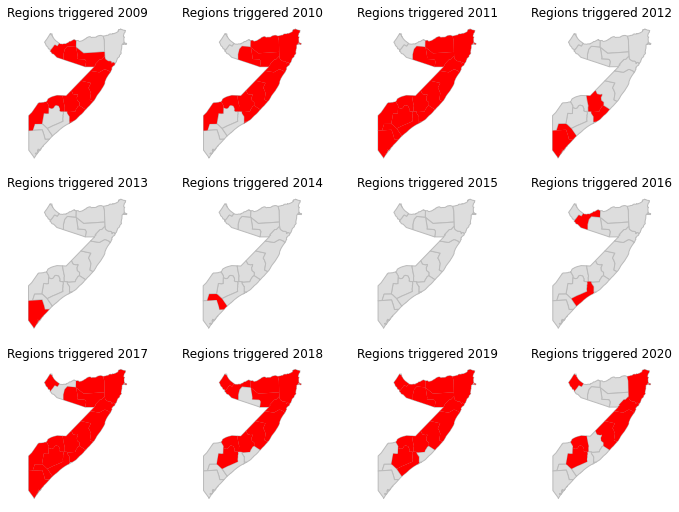

In [16]:
plot_regions_trig(dict_fan["an1"]["df"])

In [17]:
def plot_aff_dates(df_d,df_trig,col,shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm1_UNDP.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["admin1Name","geometry"]].merge(df_d,on="admin1Name",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks" #'equalinterval' 
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14, y=0.92)
    plt.show()

In [18]:
#plot_aff_dates(df_fadm,dict_fan["an1"]["df"],"perc_ML1_4",title="Percentage of population projected in IPC4+ in ML1 for the dates the trigger is met")

#### Trigger analysis Global IPC data
One of the goals was to compare the two sources of IPC data. Below are the results on the Global IPC data with the final chosen trigger

In [19]:
df_gadm=pd.read_csv(f"../Data/GlobalIPCProcessed/{country}_globalipc_admin1{suffix}.csv")

NameError: name 'suffix' is not defined

In [ ]:
glob_adm1c="ADMIN1"

In [ ]:
df_gadm=add_columns(df_gadm)

In [ ]:
df_gadm.head(n=3)

In [ ]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_gadm["trigger_ML1_4_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",4,20),axis=1)
df_gadm["trigger_ML1_3_30"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_gadm["trigger_ML1_3_5i"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)
df_gadm["trigger_ML2_4_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",4,20),axis=1)
df_gadm["trigger_ML2_3_30"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",3,30),axis=1)
df_gadm["trigger_ML2_3_5i"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML2",3,5),axis=1)

In [ ]:
#initialize dict with all the analyses
dict_gan={}

In [ ]:
#currently (Oct 2020) selected trigger
df_gan1=df_gadm.loc[(df_gadm["trigger_ML1_4_20"]==1) | ((df_gadm["trigger_ML1_3_30"]==1) & (df_gadm["trigger_ML1_3_5i"]==1))]
display(df_gan1.groupby(['year', 'month'], as_index=False)[glob_adm1c,'perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_gan["an1"]={"df":df_gan1,"trig_cols":["ML1_3p","CS_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)"}

In [ ]:
for k in dict_gan.keys():
    d=dict_gan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: GlobalIPC, {d}")
    df=dict_gan[k]["df"]
    df_grouped=df.groupby(['year', 'month'], as_index=False)[glob_adm1c].agg(lambda x: list(x))
    if df_grouped.empty:
        display(df_grouped)
    else:
        df_grouped[glob_adm1c]=[', '.join(map(str, l)) for l in df_grouped[glob_adm1c]]
        df_grouped["Trigger description"]=d
        df_grouped=df_grouped.rename(columns={glob_adm1c:"Regions triggered"})
        df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
        display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
        b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

### Compare with national trigger
